In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
import tqdm
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import numpy as np

# Raster figure using healpy

2242.3617892716056 1331703.1606009463


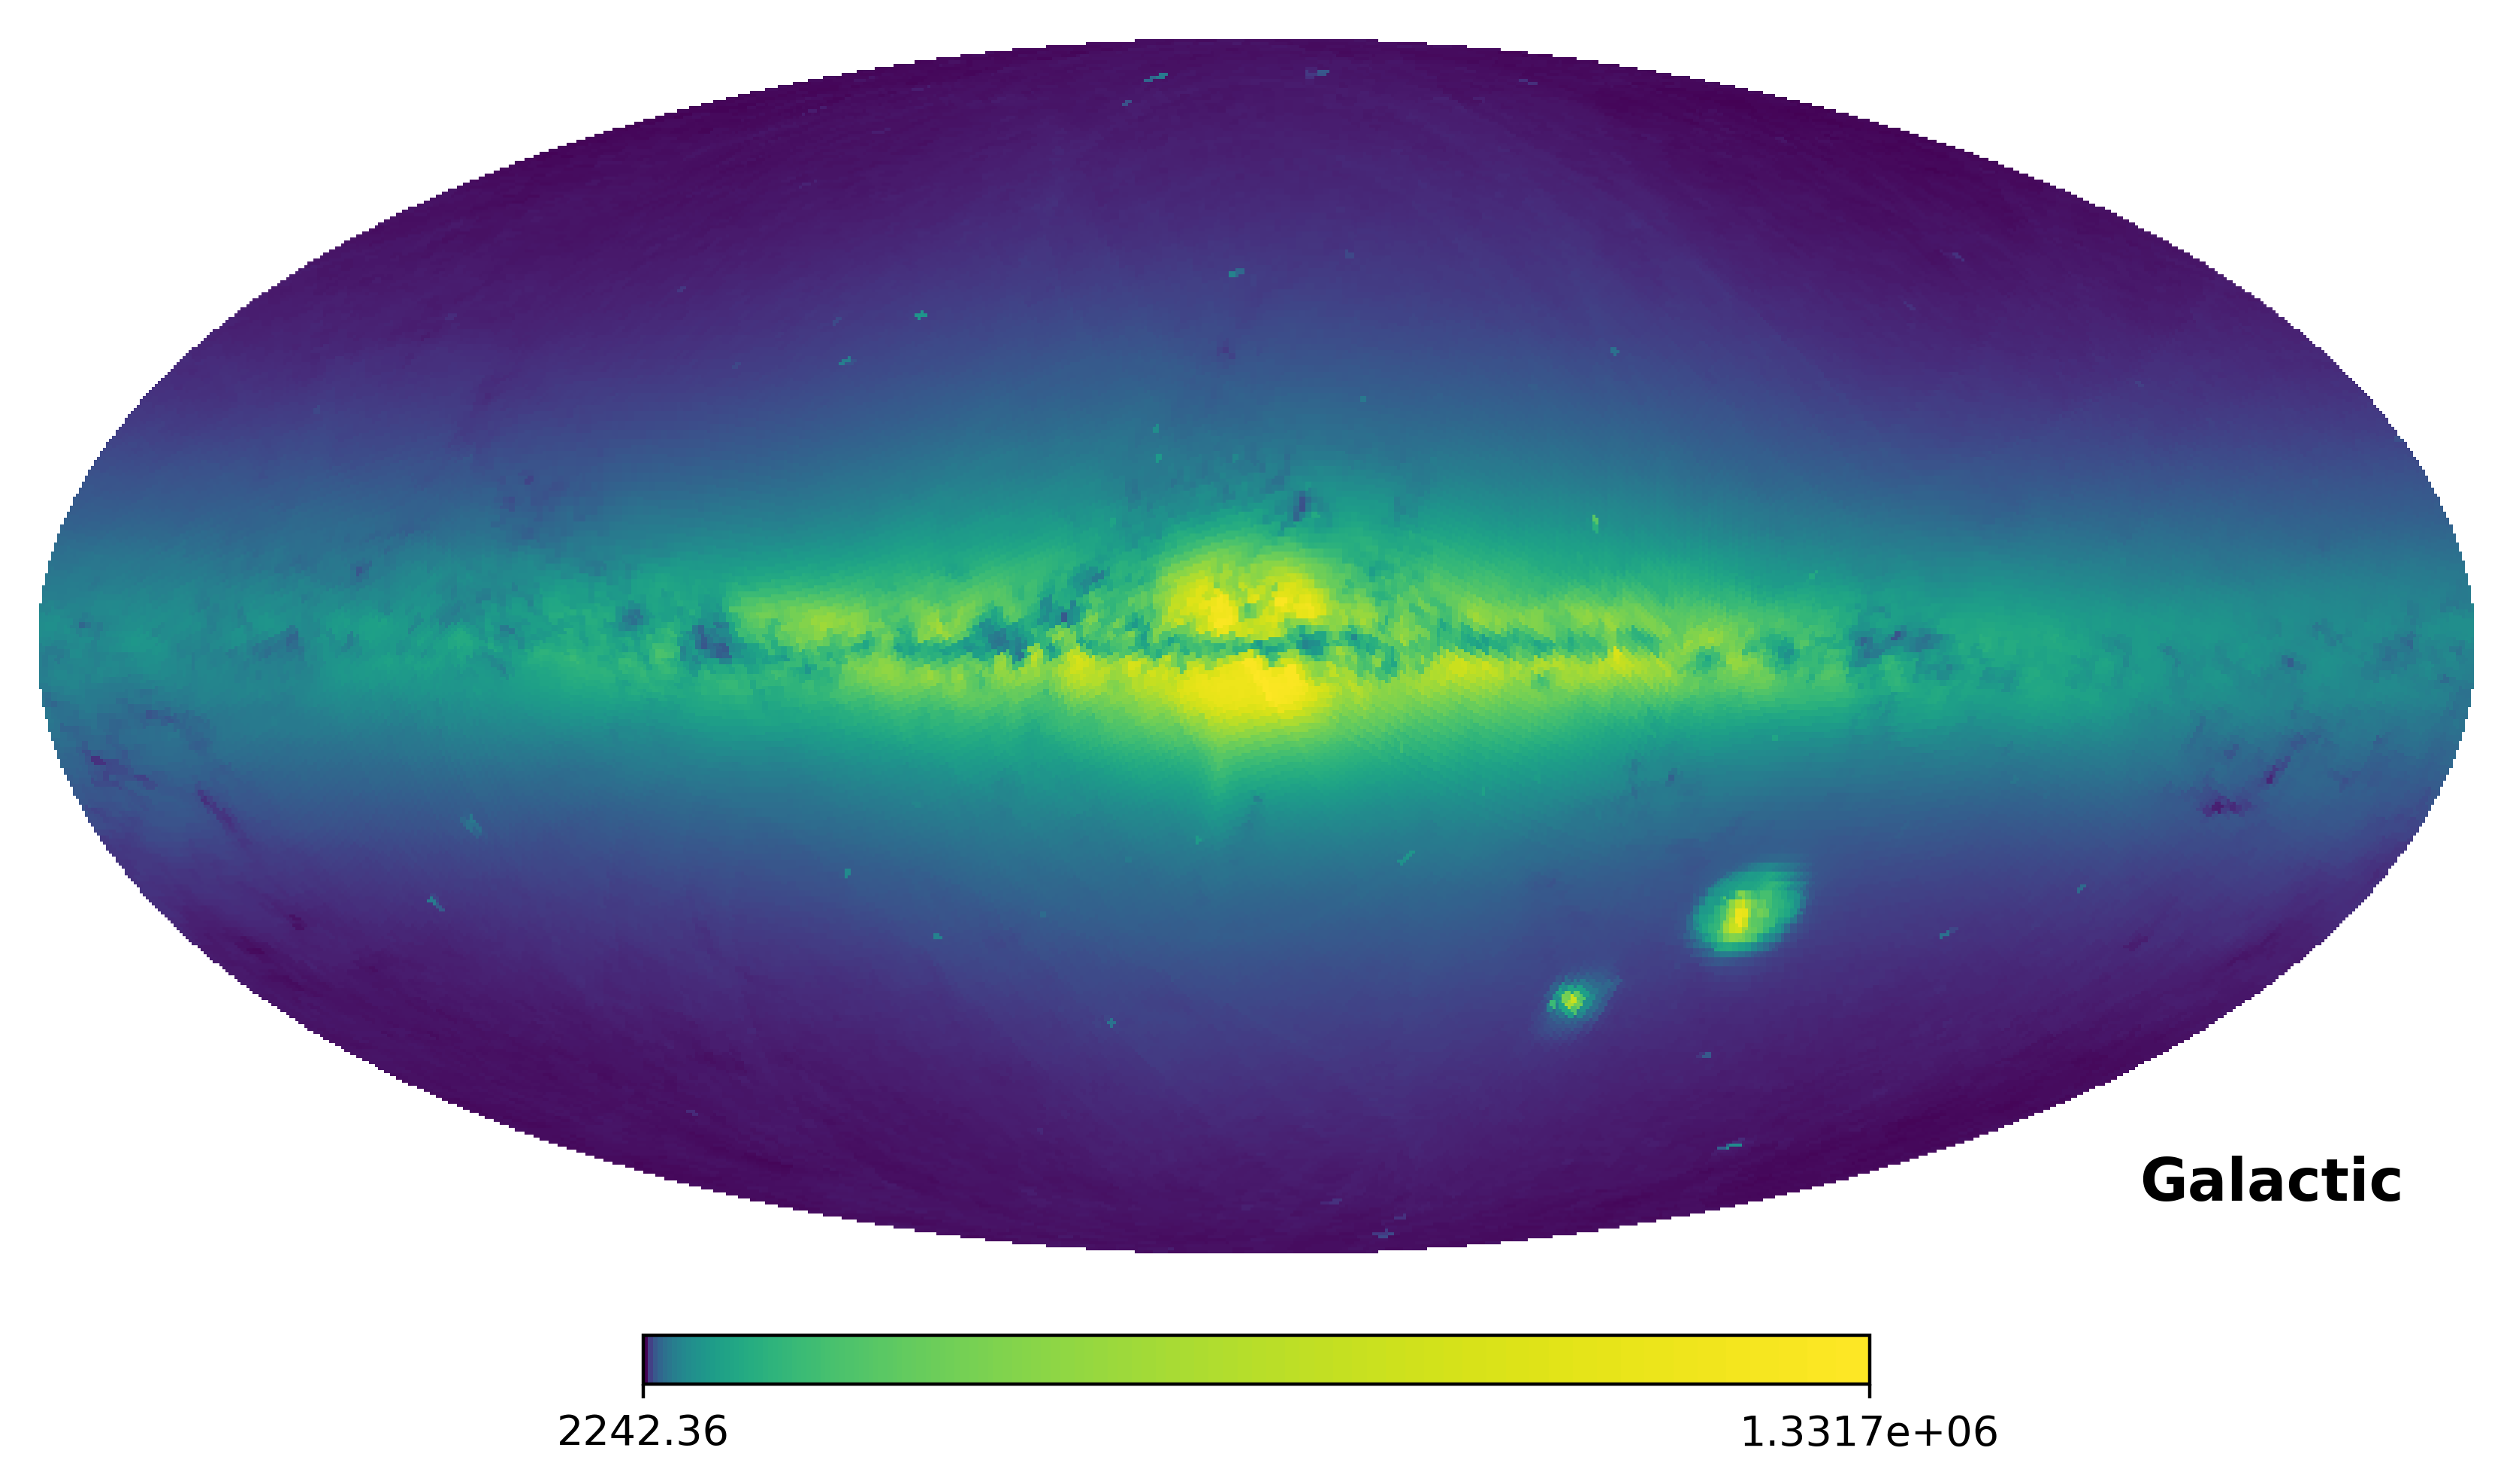

In [27]:
from healpy import read_map, ud_grade, mollview, nside2pixarea
gaia = read_map('densityMap-I_350_gaiaedr3-64.hpx',nest=True)/nside2pixarea(nside=64,degrees=True)
print(gaia.min(),gaia.max())
mollview(gaia,nest=True,coord=['C','G'],norm='log',title='')
plt.savefig('healpy.png',dpi=300,bbox_inches='tight',facecolor='w')

# Interactive vector figure with Bokeh

In [22]:
from astropy_healpix import HEALPix
from astropy import units
from healpy.projector import MollweideProj
from healpy import Rotator

# Obtain (longitude, latitude) pairs of HEALPix pixels
hp = HEALPix(nside=64, order='nested')
number_of_steps_per_side = 100
longitude, latitude = (angles.to(units.deg).value for angles in hp.boundaries_lonlat(range(hp.npix), step=number_of_steps_per_side))

# Rotate from Equatorial to Galactic
R = Rotator(coord=['C','G'])
for i in tqdm.tqdm_notebook(range(hp.npix)):
    longitude[i], latitude[i] = R(longitude[i], latitude[i],lonlat=True)

# Project to Mollweide
projector = MollweideProj()
x, y = np.zeros_like(longitude), np.zeros_like(latitude)
for i in tqdm.notebook.tqdm(range(hp.npix)):
    x[i], y[i] = projector.ang2xy(theta=longitude[i],phi=latitude[i],lonlat=True)


/Users/douglasboubert/anaconda3/envs/brainnwave/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/49152 [00:00<?, ?it/s]

  0%|          | 0/49152 [00:00<?, ?it/s]

In [23]:
from shapely.geometry import Polygon, MultiPolygon

# Connect two points in a Mollweide projection with an arc along the boundary
def generate_fill(x1,y1,x2,y2):
    t1 = np.arctan2(2*y1,x1)
    t2 = np.arctan2(2*y2,x2)
    if np.abs(t2 - t1) > np.pi:
        t2 += np.sign(t1)*2.0*np.pi
    tfill = np.linspace(t1,t2,number_of_steps_per_side)
    return 2.0*np.cos(tfill),np.sin(tfill)

# Process pixel boundaries to find jumps across longitude = 180 degrees
shapes = []
for i in tqdm.notebook.tqdm(range(hp.npix)):
    
    # Find jumps in the edge locations
    d = np.sqrt(np.diff(x[i],prepend=x[i,-1])**2.0+np.diff(y[i],prepend=y[i,-1])**2.0)
    gaps = np.where(d>0.5)[0]

    # Deal with three cases
    if gaps.size == 2:
        g1,g2 = gaps
        fill_x, fill_y = generate_fill(x[i,g1-1],y[i,g1-1],x[i,g2],y[i,g2])
        p1 = Polygon(np.stack([np.concatenate([x[i,:g1],fill_x,x[i,g2:]]),np.concatenate([y[i,:g1],fill_y,y[i,g2:]])]).T)
        fill_x, fill_y = generate_fill(x[i,g1],y[i,g1],x[i,g2-1],y[i,g2-1])
        p2 = Polygon(np.stack([np.concatenate([x[i,g2-1:g1:-1],fill_x]),np.concatenate([y[i,g2-1:g1:-1],fill_y])]).T)
        p = MultiPolygon([p1,p2])
    elif gaps.size == 1:
        g1 = gaps[0]
        fill_x, fill_y = generate_fill(x[i,g1-1],y[i,g1-1],x[i,g1],y[i,g1])
        p = Polygon(np.stack([np.concatenate([x[i,:g1],fill_x,x[i,g1:]]),np.concatenate([y[i,:g1],fill_y,y[i,g1:]])]).T)
    else:
        p = Polygon(np.stack([x[i],y[i]]).T)
    
    # Store a simplification of the polygons
    shapes.append(p.simplify(0.001, preserve_topology=True))

# Output to a shapefile
import geopandas as gpd
gdf = gpd.GeoDataFrame(geometry=shapes)  # outmulti is already a list
gdf.to_file(filename=f'./shapefiles/healpixmaps.shp', driver='ESRI Shapefile')

  0%|          | 0/49152 [00:00<?, ?it/s]

In [24]:
# Load in the shapefile and add columns
import geopandas as gpd
geodata = gpd.read_file('./shapefiles/healpixmaps.shp')
geodata['log10_source_density'] = np.log10(gaia)
geodata['source_density'] = gaia
geodata = geodata.explode() # Expand MultiPolygons to multiple Polygons

# Transform polygons into (x,y) coordinates
def getPolyCoords(row, geom, coord_type):
    if coord_type == 'x':
        return list(row[geom].exterior.coords.xy[0])
    elif coord_type == 'y':
        return list(row[geom].exterior.coords.xy[1])

geodata['x'] = geodata.apply(getPolyCoords, geom = 'geometry', coord_type = 'x', axis = 1)
geodata['y'] = geodata.apply(getPolyCoords, geom = 'geometry', coord_type = 'y', axis = 1)
geodata.drop('geometry', axis = 1, inplace=True)

In [25]:
# We are going to create an interactive bokeh plot
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LogColorMapper, ColorBar, HoverTool

# Create source for bokeh plot
source = ColumnDataSource(geodata)

# Create palette
from matplotlib import colors
palette = [colors.to_hex(plt.cm.viridis(f)) for f in np.arange(100)/99]

# Instantiate LogColorMapper
color_mapper = LogColorMapper(palette = palette, low = 1000, high = 1000000)

# Create bokeh figure
tools = 'wheel_zoom,pan,reset,hover'
plot = figure(title = 'Number of Gaia EDR3 stars per square degree', plot_height=450, plot_width=700, toolbar_location='above', tools=tools, active_scroll="wheel_zoom",lod_factor = 1000,lod_interval=100,lod_threshold=10000,lod_timeout=100)

#Add patch renderer to figure - these are the shapes of the postcode areas
plot.patches('x','y', source=source, fill_alpha=1, fill_color={'field':'source_density' , 'transform':color_mapper}, line_color={'field':'source_density' , 'transform':color_mapper})

# Add border
t = np.linspace(0,1,1000)*2.0*np.pi
plot.line(2.0*np.cos(t),np.sin(t),line_width=1,line_color='black')

# Add the tooltips when you hover over a patch
hover = plot.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Stars per square degree", "@source_density{0.0}")]

# Customise plot
plot.axis.visible = False
plot.outline_line_color = None
plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None
plot.y_range.start = -1.05
plot.y_range.end = 1.05
plot.x_range.start = -2.05
plot.x_range.end = 2.05

# Add colour bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,location='center', orientation='horizontal')
plot.add_layout(color_bar, 'below')

# Combine plot and slider and output
layout = plot
output_file("./healpixmaps.html")
show(layout)